In [2]:
from transformers import AutoTokenizer
# from transformers import DistilBertTokenizer
from datasets import load_dataset
from transformers import AutoModel
import torch

In [3]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

text = "Tokenizing text is a core task of NLP."

encoded_text = tokenizer(text)
# encoded_text = distilbert_tokenizer(text)
print(encoded_text)

tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)
print(tokenizer.convert_tokens_to_string(tokens))

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']
[CLS] tokenizing text is a core task of nlp. [SEP]


In [4]:
print("*****************Datasets****************************")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions = load_dataset("emotion")

print(tokenize(emotions["train"][:2]))

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

print(emotions_encoded["train"].column_names)

*****************Datasets****************************
{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}
['text', 'label', 'input_ids', 'attention_mask']


In [5]:
print("*****************Datasets****************************")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions = load_dataset("emotion")

print(tokenize(emotions["train"][:2]))

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

print(emotions_encoded["train"].column_names)

print("**************Using pretrained models****************")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

print("****************Extracting the last hidden states*********")

text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
    if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

*****************Datasets****************************
{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}
['text', 'label', 'input_ids', 'attention_mask']
**************Using pretrained models****************
****************Extracting the last hidden states*********
Input tensor shape: torch.Size([1, 6])
BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661

************Creating a feature matrix***************
X_train.shape:- (16000, 768), X_valid.shape:- (2000, 768)
***************Visualizing the training set***************
          X         Y  label
0  4.290516  6.726445      0
1 -2.992782  5.979086      0
2  5.392933  3.127244      3
3 -2.288411  4.056259      2
4 -3.292583  4.119050      3


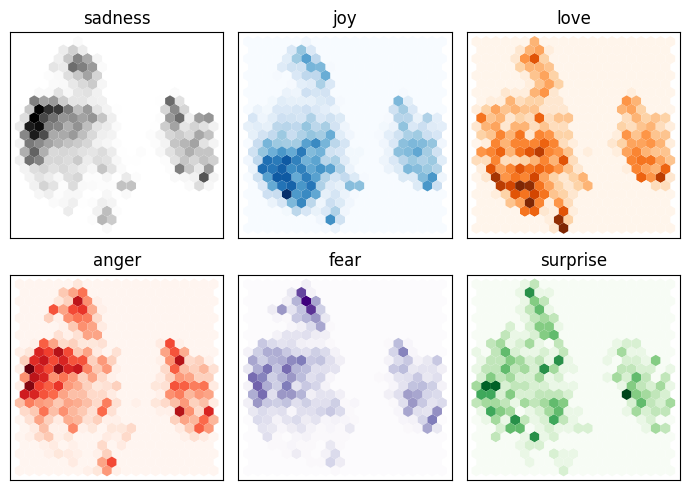

In [6]:
print("************Creating a feature matrix***************")

import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(f"X_train.shape:- {X_train.shape}, X_valid.shape:- {X_valid.shape}")

print("***************Visualizing the training set***************")

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
print(df_emb.head())

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
    gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()
# plt.savefig("plot/Visualizing_the_training_set.png")

# Training a simple classifier

In [7]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [8]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

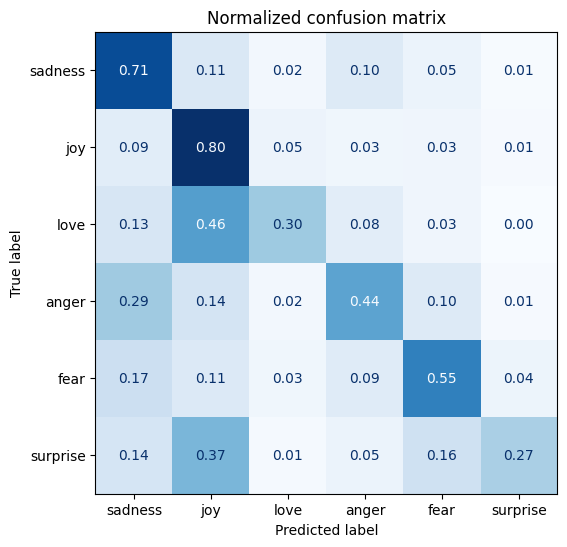

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

Fine-Tuning Transformers

In [10]:
from transformers import AutoModelForSequenceClassification

num_labels = 6

model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [12]:
from huggingface_hub import notebook_login
notebook_login()

In [15]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")


/mnt/e/Users/piyus/Documents/self_study/llm_nlp_huggingface_study/llm_huggingface/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
compute_metrics=compute_metrics,
train_dataset=emotions_encoded["train"],
eval_dataset=emotions_encoded["validation"],
tokenizer=tokenizer)
trainer.train();

/tmp/ipykernel_2777/3574550243.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.816800,0.308007,0.910500,0.909850
2,0.249900,0.216743,0.928500,0.928459


In [17]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [18]:
preds_output.metrics

{'test_loss': 0.2167433351278305,
 'test_accuracy': 0.9285,
 'test_f1': 0.9284590242751913,
 'test_runtime': 9.3334,
 'test_samples_per_second': 214.283,
 'test_steps_per_second': 3.429}

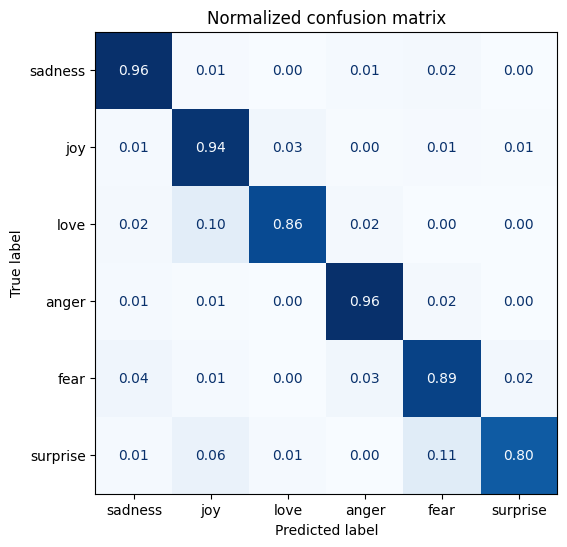

In [19]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

Error analysis

In [22]:
from torch.nn.functional import cross_entropy

def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

def forward_pass_with_label(batch):
# Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

#Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

df_test.sort_values("loss", ascending=False).head(10)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,5.587618
1801,i feel that he was being overshadowed by the s...,love,sadness,5.329011
1963,i called myself pro life and voted for perry w...,joy,sadness,5.219961
1509,i guess this is a memoir so it feels like that...,joy,fear,4.930404
1274,i am going to several holiday parties and i ca...,joy,sadness,4.845147
465,i would eventually go in to these stores but i...,joy,fear,4.779785
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.777266
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.672486
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.662622
765,i feel super awkward and out of place right now,joy,sadness,4.596069


In [23]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.018069
1205,i log on feeling vaguely sociable and after a ...,joy,joy,0.018221
578,i got to christmas feeling positive about the ...,joy,joy,0.018394
1873,i feel practically virtuous this month i have ...,joy,joy,0.018429
604,i don t like to use the h word recklessly but ...,joy,joy,0.018495
845,i already feel very glamorous have a great day...,joy,joy,0.018761
400,i are just relaxing together and i feel ecstat...,joy,joy,0.018987
199,i feel invigorated full of energy ready for th...,joy,joy,0.018993
19,i had lunch with an old friend and it was nice...,joy,joy,0.019021
1780,ive explained that he is very creative and lov...,joy,joy,0.019025


Saving and sharing the model

In [24]:
trainer.push_to_hub(commit_message="Training completed!")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/piyushghate17/distilbert-base-uncased-finetuned-emotion/commit/5c022025a5f246921049d812abc7f92c3d27abaf', commit_message='Training completed!', commit_description='', oid='5c022025a5f246921049d812abc7f92c3d27abaf', pr_url=None, repo_url=RepoUrl('https://huggingface.co/piyushghate17/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='piyushghate17/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

In [25]:
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "piyushghate17/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

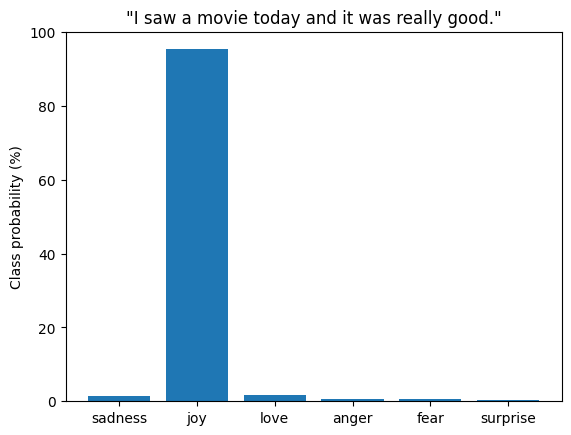

In [29]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()